In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from urllib.request import urlopen
import json
from credentials import *
from entsoe import EntsoePandasClient
from entsoe.mappings import lookup_area
from pycaret.time_series import *
import logging

mpl.rcParams['figure.dpi'] = 150
logging.disable(logging.CRITICAL)


### Loading and Joining Datasets

In [3]:
country_code = 'ES'
area = lookup_area(country_code)

df_countries = pd.read_csv('countries.csv', index_col = 'country')

lat = df_countries.loc[country_code].latitude.astype('str')
lon = df_countries.loc[country_code].longitude.astype('str')

In [4]:
# Get weather data from Open Meteo API

url = 'https://api.open-meteo.com/v1/forecast?' + \
      'latitude=' + lat + \
      '&longitude=' + lon + \
      '&hourly=temperature_2m,relativehumidity_2m,precipitation,cloudcover,direct_radiation,direct_normal_irradiance,windspeed_10m,winddirection_10m,windgusts_10m,pressure_msl&past_days=31'

response = urlopen(url)
data_json = json.loads(response.read())

df_weather = pd.DataFrame(data_json['hourly'])
df_weather.set_index(pd.DatetimeIndex(pd.to_datetime(df_weather['time'])), inplace = True)
df_weather['cloud_ma'] = df_weather['cloudcover'].rolling(24, min_periods = 1, center = True).mean()
df_weather['pressure_msl'].fillna(method = 'bfill', inplace = True)
df_weather.head()

,relativehumidity_2m,direct_radiation,windgusts_10m,temperature_2m,winddirection_10m,direct_normal_irradiance,precipitation,cloudcover,time,windspeed_10m,pressure_msl,cloud_ma
time,,,,,,,,,,,,
2022-06-09 00:00:00,57.0,0.0,5.0,20.6,257.0,0.0,0.0,100.0,2022-06-09T00:00,3.3,1015.6,15.000000
2022-06-09 01:00:00,59.0,0.0,6.8,20.0,257.0,0.0,0.0,50.0,2022-06-09T01:00,3.3,1015.6,13.923077
2022-06-09 02:00:00,63.0,0.0,6.1,19.4,279.0,0.0,0.0,30.0,2022-06-09T02:00,2.2,1015.6,12.928571
2022-06-09 03:00:00,67.0,0.0,5.4,18.5,320.0,0.0,0.0,0.0,2022-06-09T03:00,2.8,1015.6,12.066667
2022-06-09 04:00:00,72.0,0.0,6.1,17.6,324.0,0.0,0.0,0.0,2022-06-09T04:00,3.1,1015.6,11.312500


In [5]:
# Get energy data from ENTSO-E API

client = EntsoePandasClient(api_key=get_token())
end = pd.Timestamp.now(tz=area.tz) # - pd.DateOffset(days=10)
start = end - pd.DateOffset(months = 1)
%time df_energy = client.query_generation(area, start=start,end=end, nett = True, psr_type=None)
df_energy.set_index(df_energy.index.tz_convert(None), inplace = True)
df_energy = df_energy.resample('H').mean()


Wall time: 26.9 s


In [6]:
# Join energy and weather data

df_join = df_energy.join(df_weather, how = 'inner')

df_join.head()

,Biomass,Fossil Brown coal/Lignite,Fossil Coal-derived gas,Fossil Gas,Fossil Hard coal,Fossil Oil,Fossil Oil shale,Fossil Peat,Geothermal,Hydro Pumped Storage,...,windgusts_10m,temperature_2m,winddirection_10m,direct_normal_irradiance,precipitation,cloudcover,time,windspeed_10m,pressure_msl,cloud_ma
2022-06-10 19:00:00,509.0,0.0,0.0,9764.0,746.0,188.0,0.0,0.0,0.0,-8.0,...,8.6,33.9,189.0,469.7,0.0,0.0,2022-06-10T19:00,2.2,1015.6,34.333333
2022-06-10 20:00:00,512.0,0.0,0.0,9676.0,752.0,188.0,0.0,0.0,0.0,0.0,...,4.7,32.2,233.0,80.3,0.0,19.0,2022-06-10T20:00,1.8,1015.6,35.833333
2022-06-10 21:00:00,512.0,0.0,0.0,9405.0,772.0,188.0,0.0,0.0,0.0,0.0,...,2.9,30.6,262.0,0.0,0.0,34.0,2022-06-10T21:00,2.5,1015.6,36.416667
2022-06-10 22:00:00,529.0,0.0,0.0,7885.0,720.0,177.0,0.0,0.0,0.0,0.0,...,5.8,28.6,288.0,0.0,0.0,98.0,2022-06-10T22:00,3.4,1015.6,39.041667
2022-06-10 23:00:00,519.0,0.0,0.0,7360.0,710.0,172.0,0.0,0.0,0.0,0.0,...,7.6,25.6,339.0,0.0,0.0,100.0,2022-06-10T23:00,3.1,1015.6,41.458333


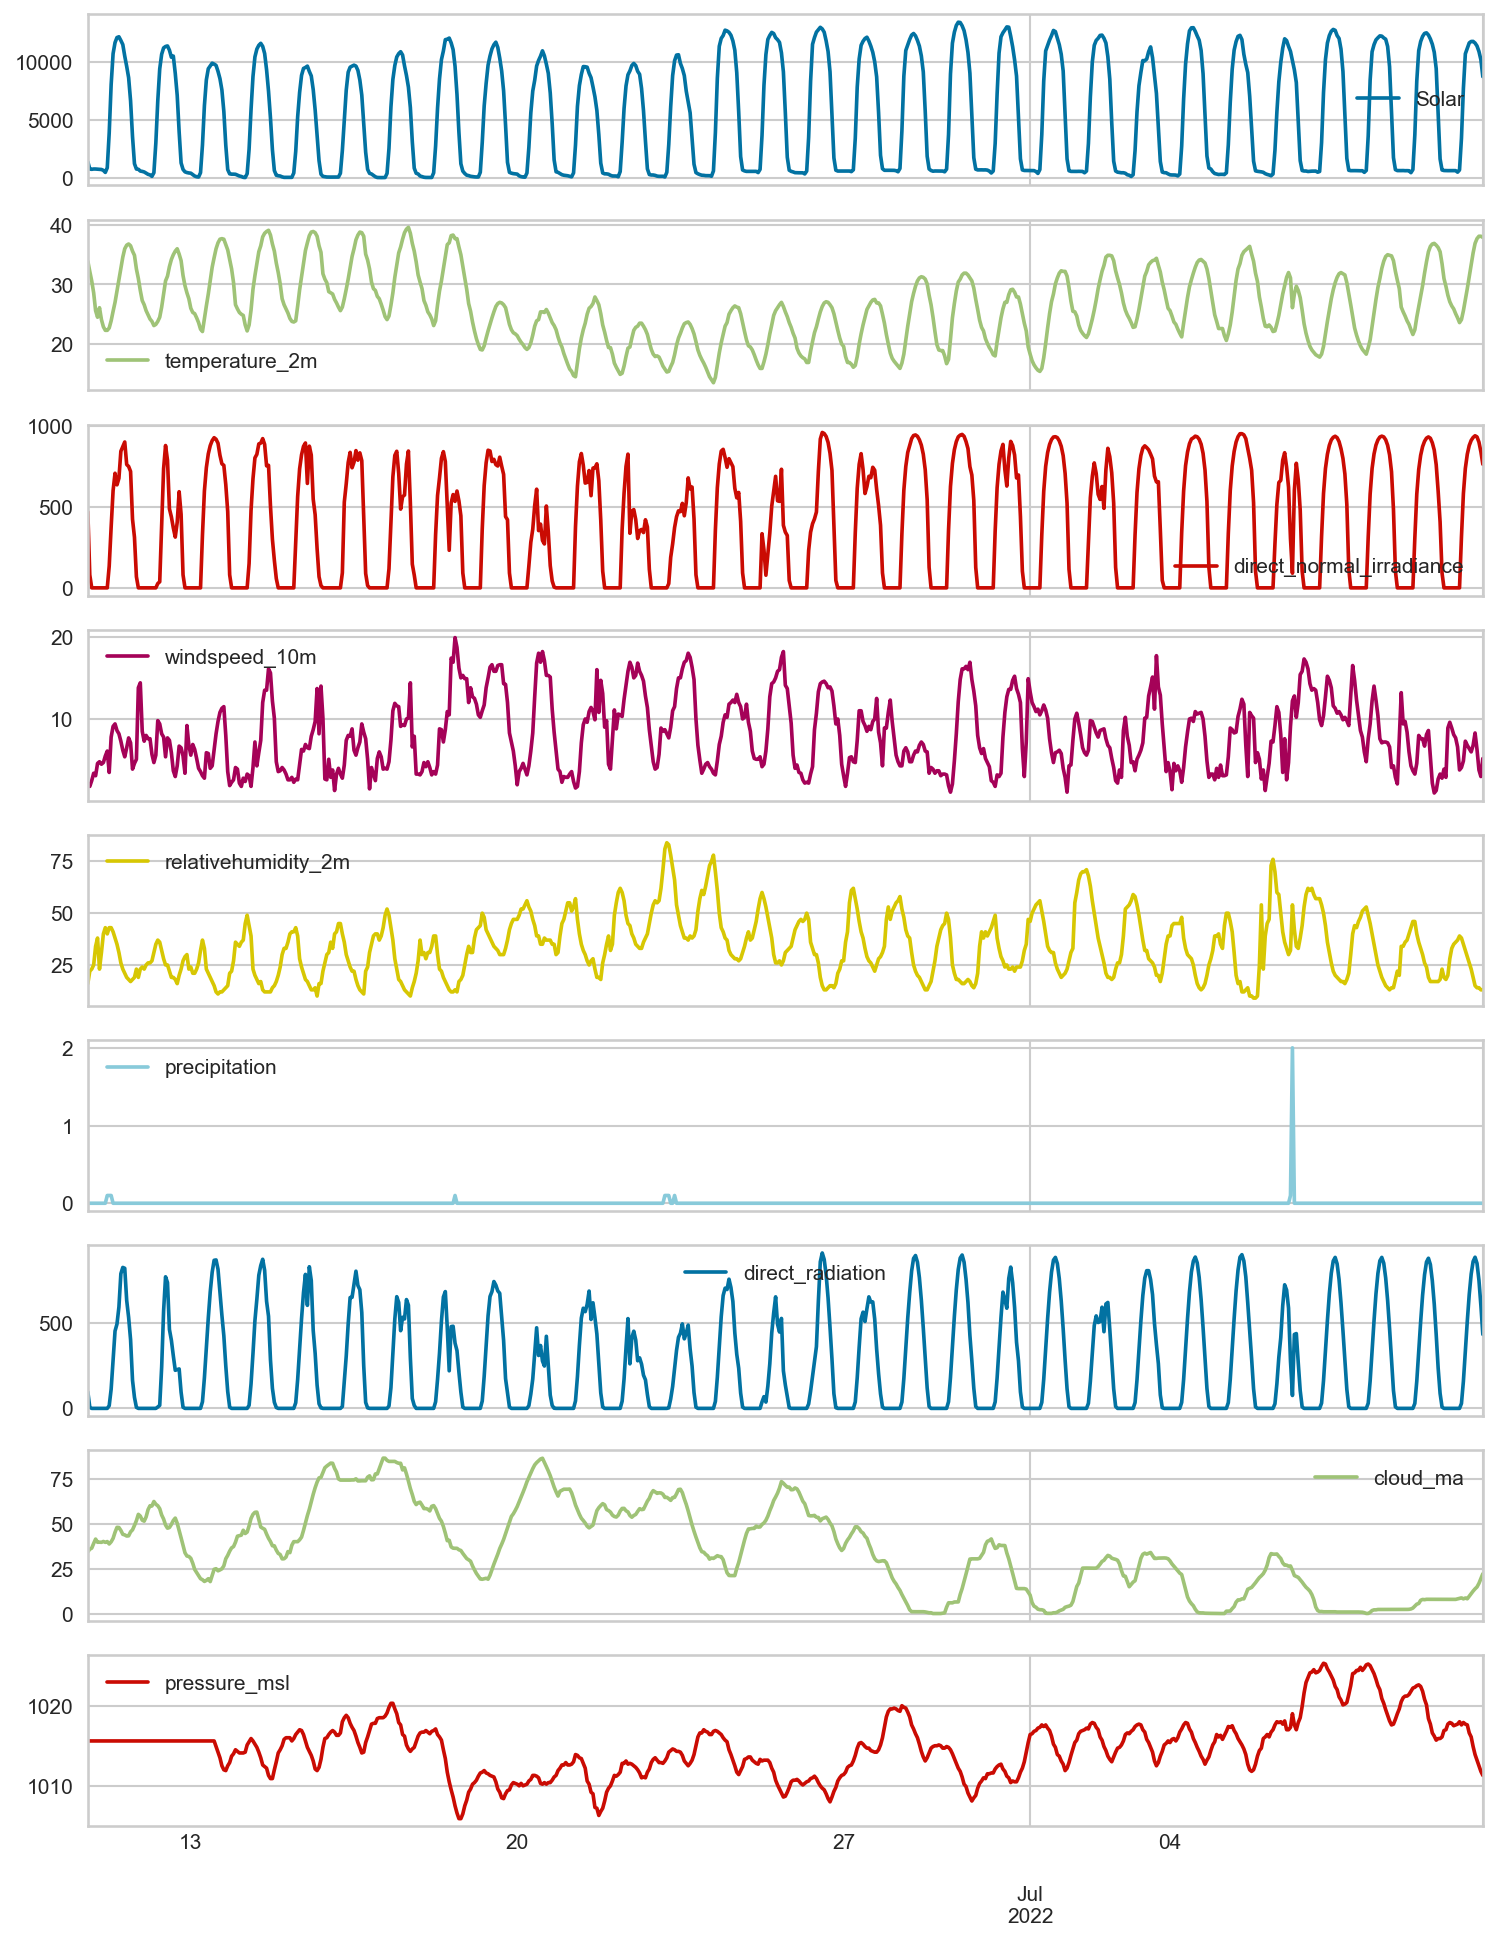

In [7]:
# Visualizing solar energy and related variables 

columns = ['Solar', 'temperature_2m', 'direct_normal_irradiance',
           'windspeed_10m', 'relativehumidity_2m', 'precipitation',
           'direct_radiation', 'cloud_ma', 'pressure_msl']

df_join[columns].plot(subplots = True, figsize = (12,16))
plt.show()

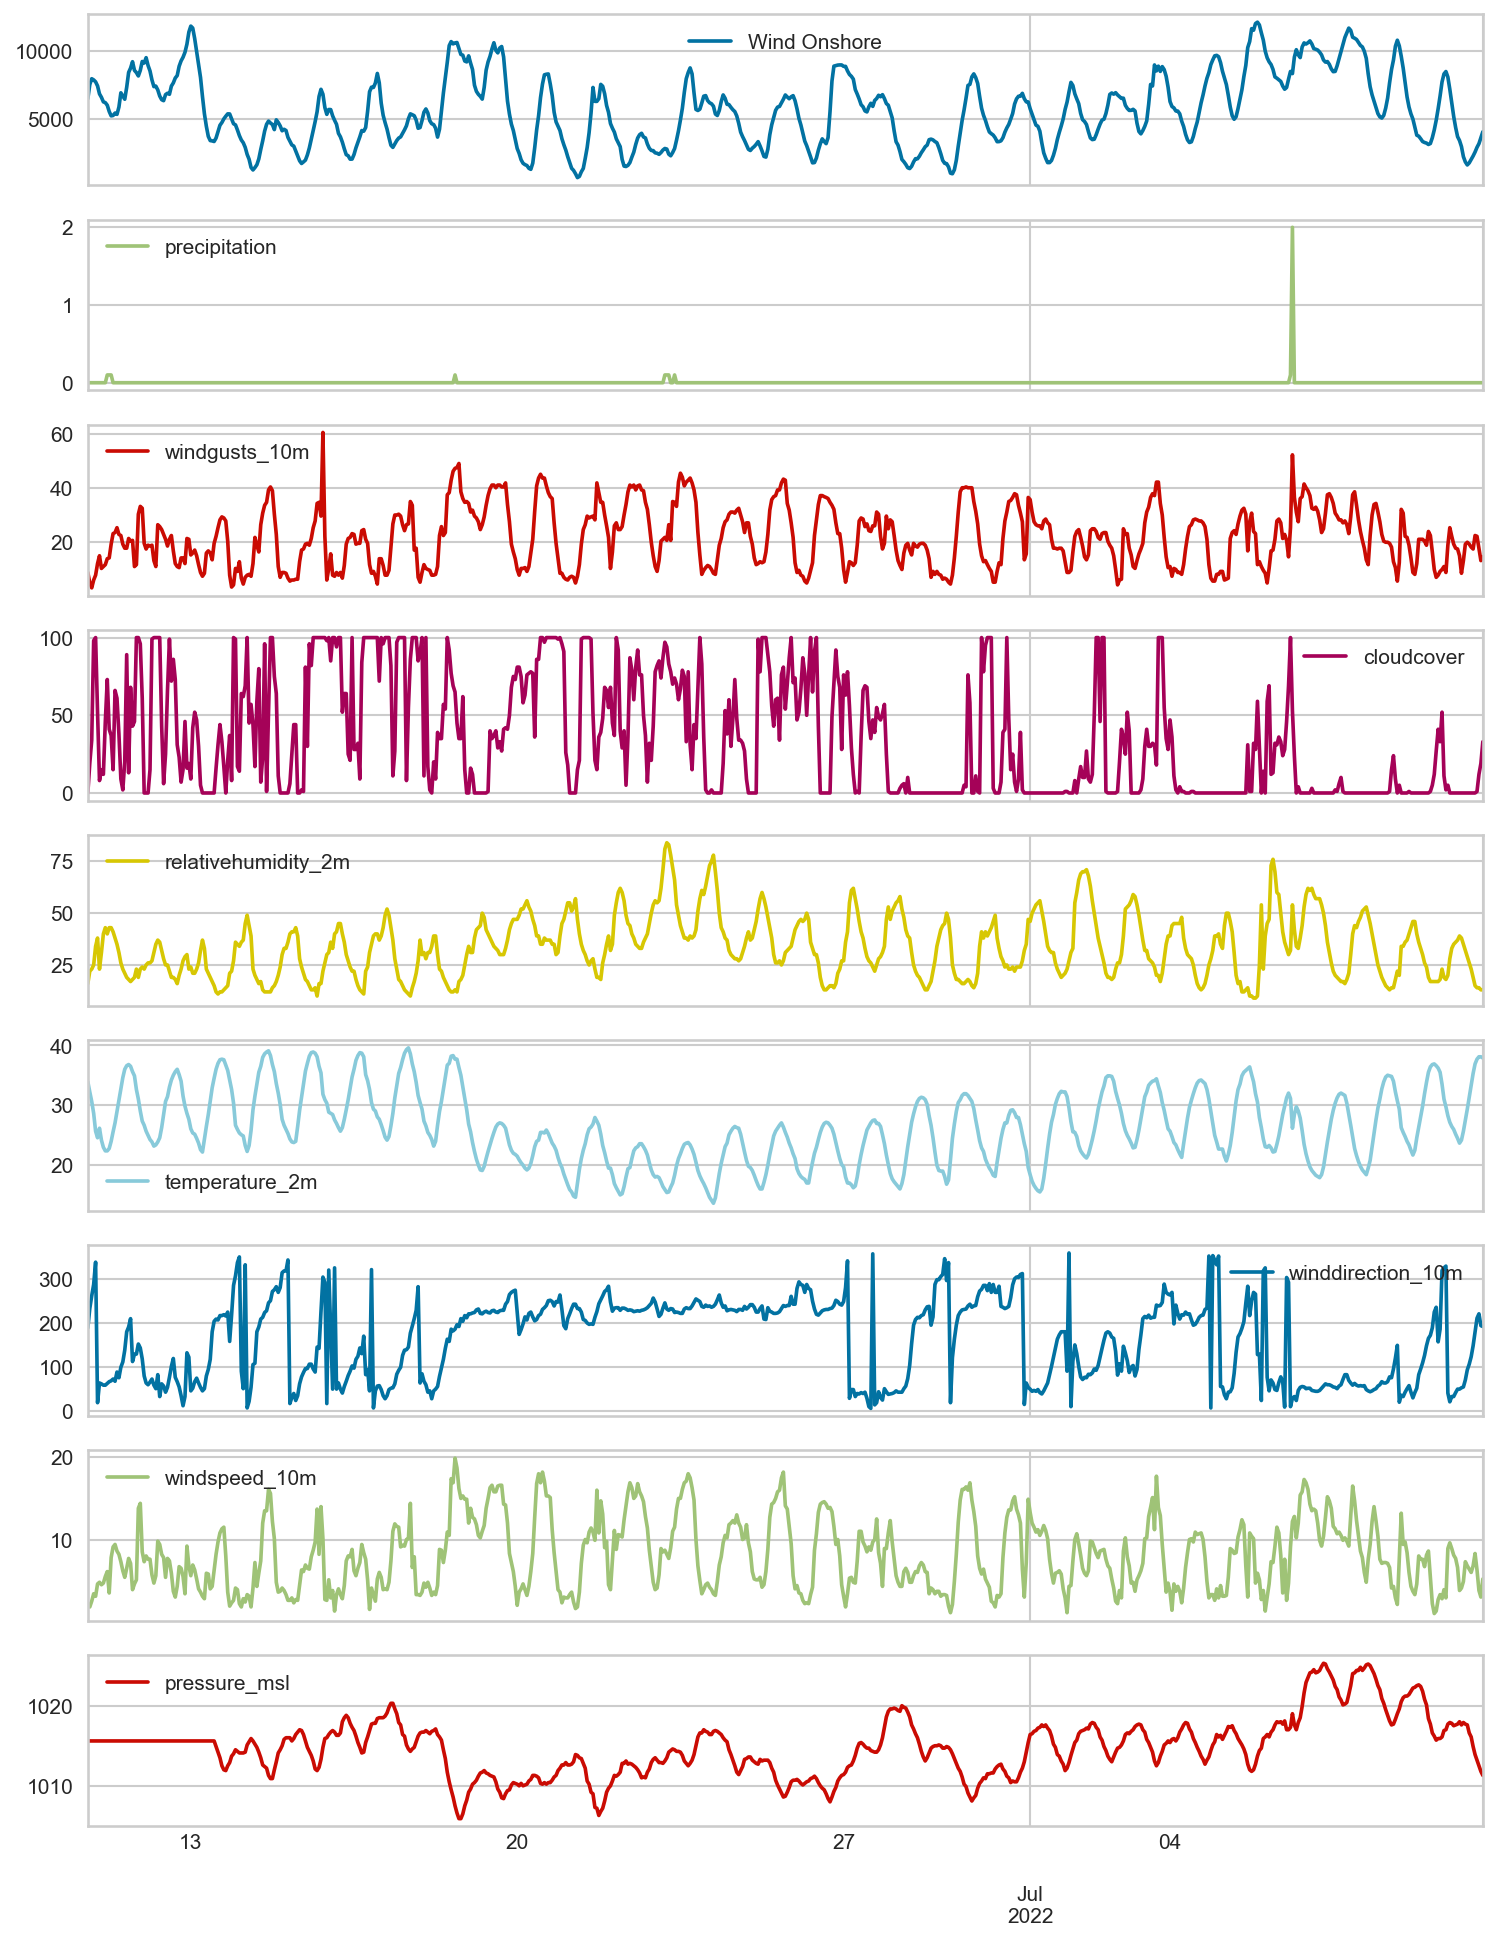

In [8]:
columns = ['Wind Onshore', 'precipitation', 'windgusts_10m', 'cloudcover', 'relativehumidity_2m',
           'temperature_2m', 'winddirection_10m', 'windspeed_10m', 'pressure_msl']

df_join[columns].plot(subplots = True, figsize = (12, 16))
plt.show()

### Forecasting with PyCaret

In [9]:
columns = ['Solar', 'direct_radiation']

ts = setup(data = df_join[columns], target = 'Solar',
           fh = 48, enforce_exogenous = False, fold = 3)
           

,Description,Value
0,session_id,7459
1,Target,Solar
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(719, 2)"
5,Transformed data shape,"(719, 2)"
6,Transformed train set shape,"(671, 2)"
7,Transformed test set shape,"(48, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [12]:
model = create_model('theta')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2022-07-02 17:00,2.0793,1.9471,983.2065,1522.5008,0.2636,0.2144,0.9043
1,2022-07-04 17:00,2.5647,2.1827,1312.4998,1827.6150,0.2435,0.2120,0.8521
2,2022-07-06 17:00,0.7687,0.6202,393.2557,514.4682,0.1527,0.1814,0.9902
Mean,NaT,1.8042,1.5834,896.3207,1288.1947,0.2199,0.2026,0.9155
SD,NaT,0.7586,0.6878,380.2756,561.1079,0.0482,0.0150,0.0570


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
df_ener